# Импорты для сети

In [1]:
import tensorflow as tf
import cv2
import os
import sys
import random
import numpy as np
import glob

from tqdm import tqdm
import tifffile as tif
from PIL import Image
from skimage.io import imread,imshow
from skimage.transform import resize
import matplotlib.pyplot as plt
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras.models import Model

%matplotlib inline

# Загрузим дсет

In [2]:
path = 'DIPLOMA/for_SSL_reversed_pics/'
def read_images_to_array(folder_path):
    images = []
    # Проходим по всем файлам в папке
    for filename in os.listdir(folder_path):
        # Полный путь к изображению
        image_path = os.path.join(folder_path, filename)
        # Читаем изображение
        img = cv2.imread(image_path)
        if img is not None:
            # Преобразуем изображение в массив NumPy и добавляем в список
            images.append(img)
    # Преобразуем список изображений в массив NumPy
    images_array = np.array(images)
    return images_array

def read_masks_to_array(folder_path):
    images = []
    # Проходим по всем файлам в папке
    for filename in os.listdir(folder_path):
        # Полный путь к изображению
        image_path = os.path.join(folder_path, filename)
        # Читаем изображение
        img = cv2.imread(image_path, 0)
        if img is not None:
            # Преобразуем изображение в массив NumPy и добавляем в список
            images.append(img)
    # Преобразуем список изображений в массив NumPy
    images_array = np.array(images)
    return images_array

train_images = read_images_to_array(path)

# Подготовим картинки

In [2]:
# def prep_image(image, size_y, size_x):
#     prepd_image = cv2.resize(image,(size_y, size_x))
#     return prepd_image

# size_x=128
# size_y=128


# train_images=[]

# for directory_path in glob.glob("Water Bodies Dataset/Images"):
#     for img_path in glob.glob(os.path.join(directory_path,"*.jpg")):
#         img=cv2.imread(img_path,cv2.IMREAD_COLOR)
#         img=prep_image(img,size_y,size_x)
#         train_images.append(img)
        
# train_images = np.array(train_images)

# train_masks = []

# for directory_path in glob.glob("Water Bodies Dataset/Masks"):
#     for mask_path in glob.glob(os.path.join(directory_path,"*.jpg")):
#         mask=cv2.imread(mask_path,0)
#         mask=prep_image(mask,size_y,size_x)
#         train_masks.append(mask)
        
# train_masks = np.array(train_masks)

# Проверим

In [3]:
len(train_images), train_images[0].shape

(4577, (256, 256, 3))

In [4]:
def normalize_images(images):
    # Преобразование значений пикселей в диапазон от 0 до 1
    normalized_images = images.astype('float32') / 255.0
    return normalized_images

train_images_normed = normalize_images(train_images)

## Выведем случайную пикчу и маску

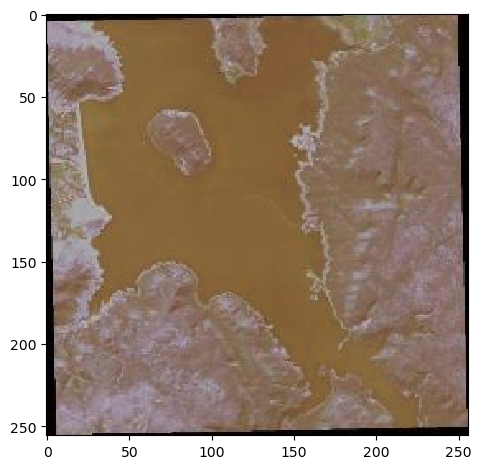

In [5]:
random_num = random.randint(0,516)
imshow(train_images_normed[random_num])
plt.show()


## U-NET model

In [5]:
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3

def ssl_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS):
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
     
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
     
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
     
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    #Expansive path 
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
     
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
     
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
     
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
     
    outputs = Conv2D(3, (1, 1), activation='sigmoid')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    
    return model

In [6]:
def get_model():
    return ssl_unet_model(IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS)

## Сведения о сети

In [7]:
model = get_model()
#model.summary()

## Запустим

In [8]:
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
x_train = train_images_normed
x_train_np = np.array(x_train)

In [9]:
import numpy as np

def create_center_black_image(original_array, size):
    """
    Создает новый массив с размерами оригинального массива,
    где центральная область остается без изменений,
    а все остальные области заполняются черными пикселями.

    Параметры:
    original_array : numpy.ndarray
        Оригинальный массив изображения.
    size : int
        Размер центральной области (квадратной) в пикселях.

    Возвращает:
    numpy.ndarray
        Новый массив с центром и черными пикселями вокруг.
    """
    # Создание нового массива numpy, заполненного черными пикселями
    new_array = np.zeros_like(original_array)

    # Определение координат центра оригинального массива
    center_x = original_array.shape[1] // 2
    center_y = original_array.shape[2] // 2

    # Копирование центральной области из оригинального массива
    new_array[:, center_x - size // 2: center_x + size // 2, center_y - size // 2: center_y + size // 2, :] = \
        original_array[:, center_x - size // 2: center_x + size // 2, center_y - size // 2: center_y + size // 2, :]

    return new_array

y_train_np = create_center_black_image(x_train_np, size=100)

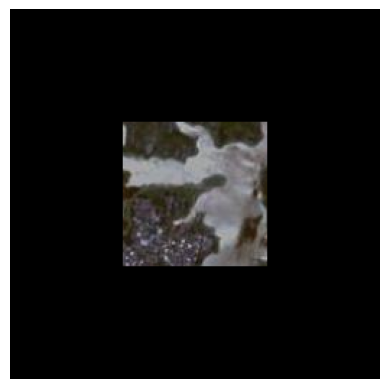

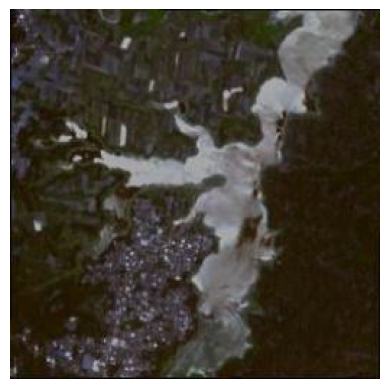

In [10]:
image_to_show = y_train_np[1]

# Отображение изображения
plt.imshow(image_to_show)
plt.axis('off')  # Отключение осей координат
plt.show()

image_to_show = x_train_np[1]
plt.imshow(image_to_show)
plt.axis('off')  # Отключение осей координат
plt.show()

In [ ]:
history=model.fit(y_train_np,
          x_train_np,
          batch_size=20, 
          epochs=20,
          verbose=1,
         )

Epoch 1/20
229/229 [==============================] - 36s 132ms/step - loss: 0.0215 - accuracy: 0.6112
Epoch 2/20
229/229 [==============================] - 28s 123ms/step - loss: 0.0151 - accuracy: 0.6559
Epoch 3/20
229/229 [==============================] - 28s 123ms/step - loss: 0.0143 - accuracy: 0.6631
Epoch 4/20
229/229 [==============================] - 28s 123ms/step - loss: 0.0137 - accuracy: 0.6766
Epoch 5/20
229/229 [==============================] - 28s 123ms/step - loss: 0.0132 - accuracy: 0.6939
Epoch 6/20
229/229 [==============================] - 28s 123ms/step - loss: 0.0124 - accuracy: 0.7339
Epoch 7/20
229/229 [==============================] - 28s 123ms/step - loss: 0.0122 - accuracy: 0.7429
Epoch 8/20
229/229 [==============================] - 28s 123ms/step - loss: 0.0121 - accuracy: 0.7492
Epoch 9/20
229/229 [==============================] - 28s 124ms/step - loss: 0.0119 - accuracy: 0.7538
Epoch 10/20
229/229 [==============================] - 28s 124ms/step - l

## Графики показывающие результаты обучения

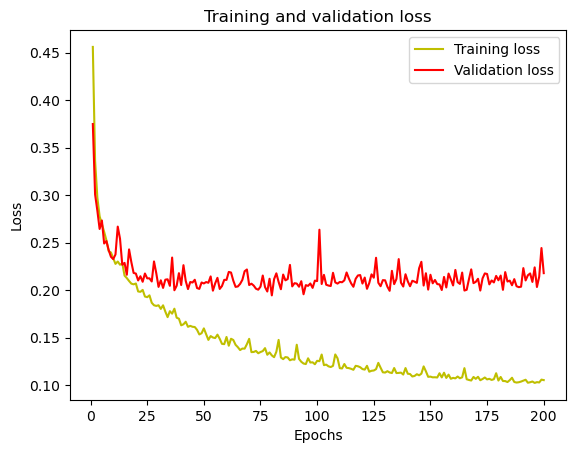

In [13]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

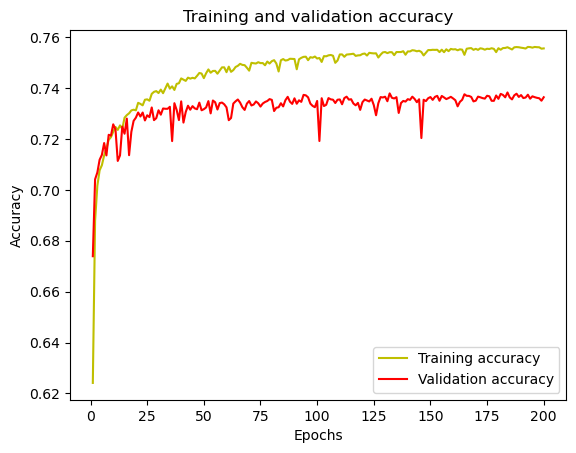

In [14]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, 'y', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Лучшие показатели

In [16]:
best_train_loss = min(history.history['loss'])
best_train_acc = max(history.history['accuracy'])

print(best_train_loss)
print(best_train_acc)

0.12279325723648071
0.7524070143699646


In [17]:
best_val_loss = min(history.history['val_loss'])
best_val_acc = max(history.history['val_accuracy'])

print(best_val_loss)
print(best_val_acc)

0.18870078027248383
0.7382009625434875


## Предсказания для 2х картинок

Original Image: 


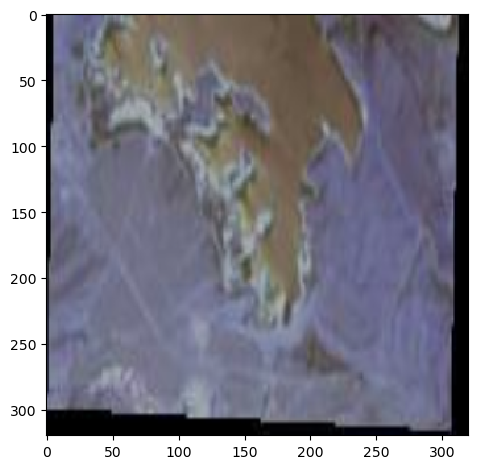

Predicted Mask: 


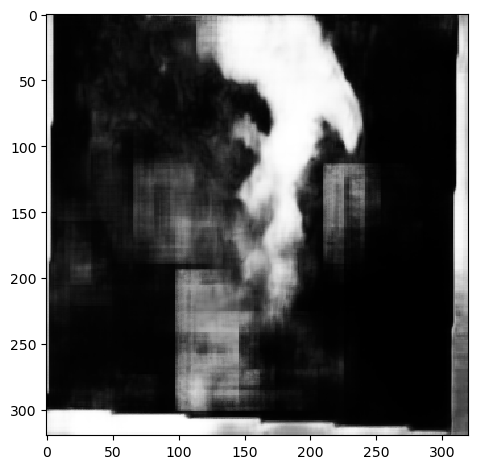

Original Image: 


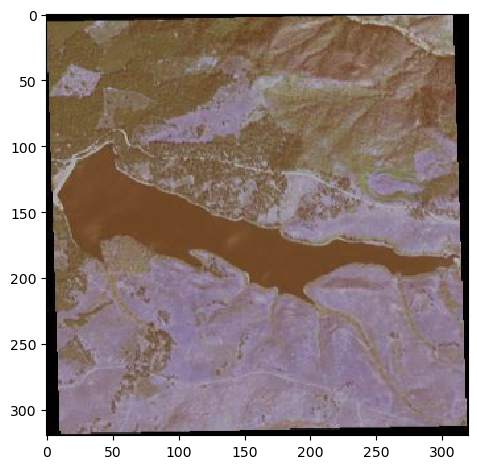

Predicted Mask: 


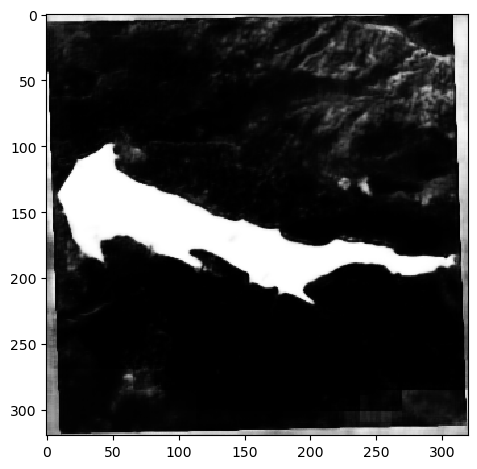

In [24]:
for i in range(0,2):    
    random_num = random.randint(0,500)
    original_image = x_val[random_num]
    imshow(original_image)
    print("Original Image: ")
    plt.show()

    original_image=np.expand_dims(original_image,axis=0)
    predicted_mask = model.predict(original_image)
    predicted_mask = predicted_mask.reshape(mask.shape)
    print("Predicted Mask: ")
    imshow(predicted_mask,cmap='grey')
    plt.show()
    i+=1

In [14]:
model.save("DIPLOMA/ssl_models/train_data_ssl_20epoches.h5")

In [110]:
#img=cv2.imread('tst2.jpg',cv2.IMREAD_COLOR)
#img=prep_image(img,crop_size,size_y,size_x)
#img = np.array(img)
#new_img = np.expand_dims(img, 0)

#pred_img = model.predict(new_img)
#pred_img = np.squeeze(pred_img)


#imshow(img)
#print("Оригинальная: ")
#plt.show()


#imshow(pred_img)
#print("Предксказанная: ")
#plt.show()